In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sys

if '..' not in sys.path:
    sys.path.append('..')

from data import ThreeBallsCollisionDataset

import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.nn.functional import mse_loss as mse_pytorch

import reservoirpy as rpy
from reservoirpy.observables import mse as mse_esn

from itertools import product
from tqdm.notebook import tqdm_notebook

from models import VanilaRNN, GRU, LSTM, ESN, SeqESN, ParallelESN, GroupedESN

rpy.verbosity(0)

0

# Importing data

In [2]:
batch_size = 32

train_data, test_data = ThreeBallsCollisionDataset.train_test_split('../data/raw/three-balls-collisions-limited-free-fall', test_frac=0.2, max_actions=1000, free_fall_fraction=0.15)

train_dataloader = DataLoader(dataset=train_data, batch_size=batch_size)
test_dataloader = DataLoader(dataset=test_data, batch_size=batch_size)

Test size:  18251
train_test_split response: test fraction rounded to 0.19999342523395208 (18251 simulations)


# Vanila RNN

VanilaRNN(
  (rnn): RNN(9, 96, batch_first=True)
  (out): Linear(in_features=96, out_features=48, bias=True)
)
Epoch 0 complete. Training loss: 272.0556672226521
Epoch 1 complete. Training loss: 6.506048539711628
Epoch 2 complete. Training loss: 5.920849450281821
Epoch 3 complete. Training loss: 5.716930696478812
Epoch 4 complete. Training loss: 5.64189988761791
Epoch 5 complete. Training loss: 5.649805458961055
Training stopped on epoch 5
Calculated loss:  tensor(0.0537, grad_fn=<PowBackward0>)


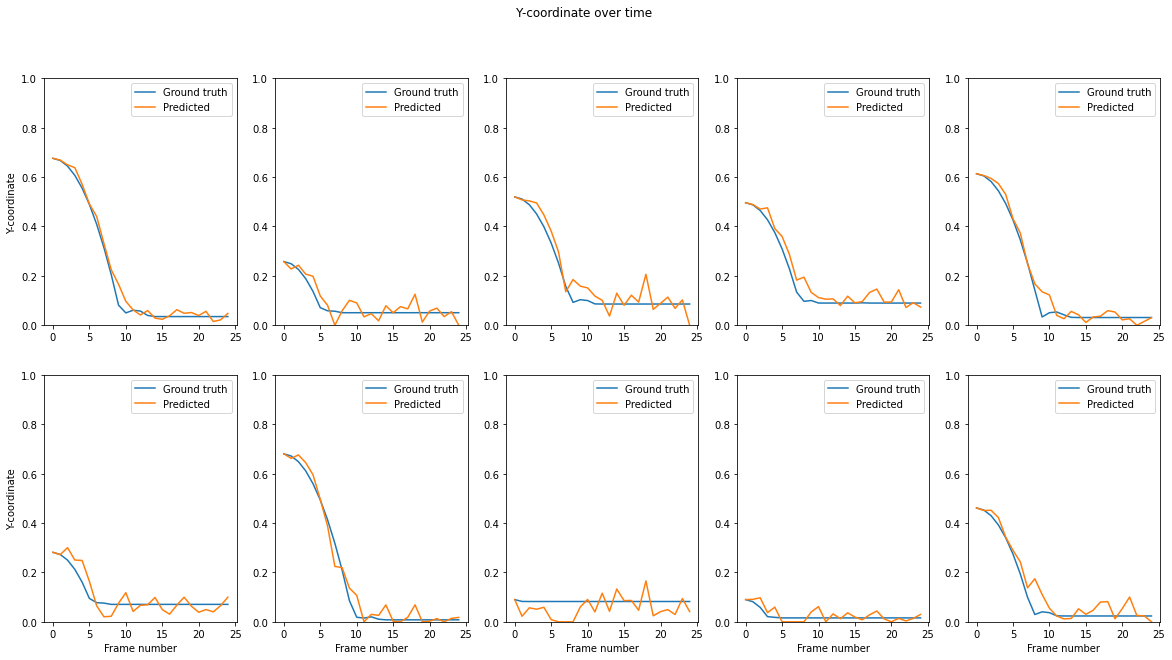

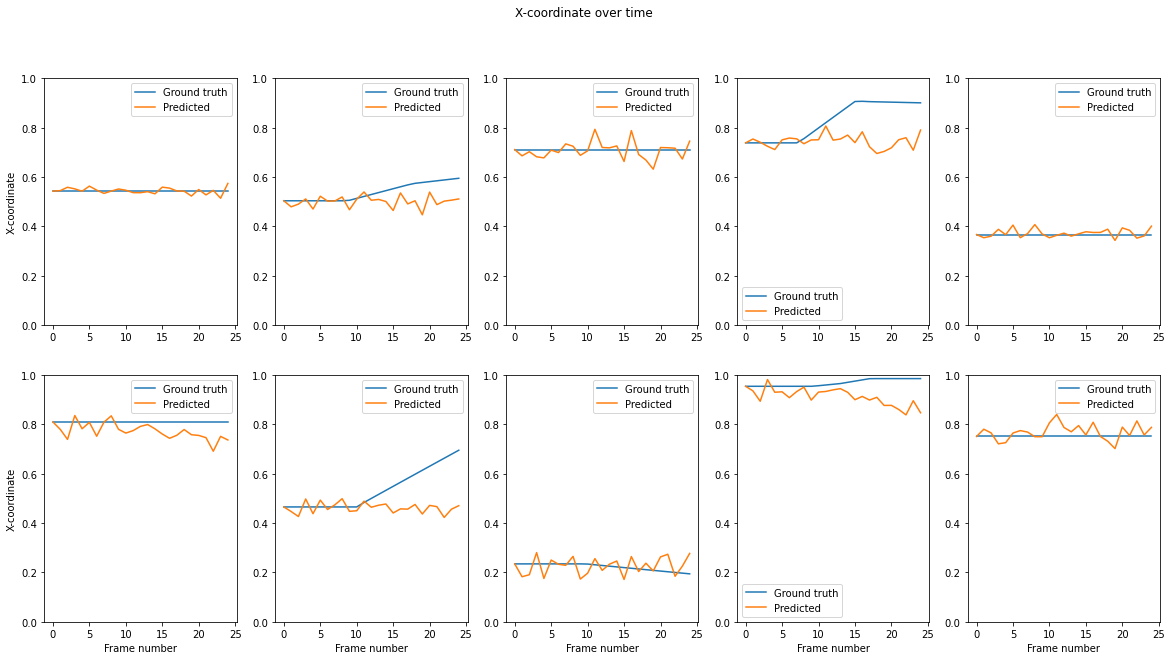

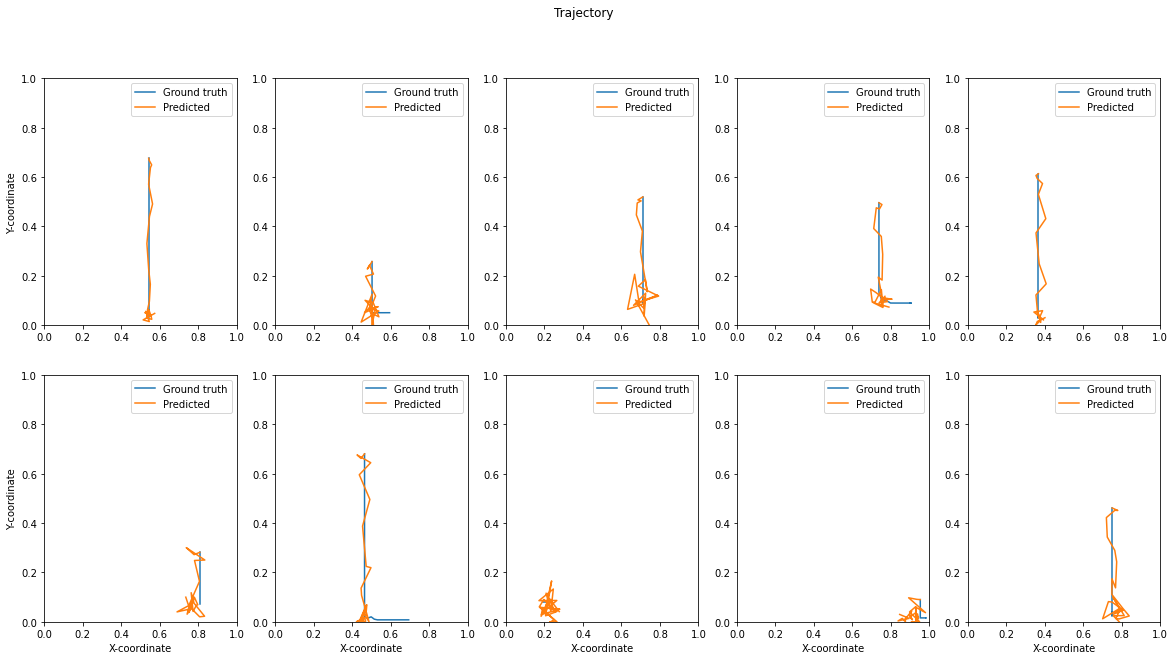

tensor(0.0537, grad_fn=<PowBackward0>)

In [9]:
vanila_rnn = VanilaRNN.train_model(train_dataloader=train_dataloader, error_threshold=1000, input_dim=9, hidden_dim=96, num_rnns=1, output_dim=48, dropout_prob=0)
VanilaRNN.calculate_loss(vanila_rnn, mse_pytorch, test_dataloader, test_data, visualize_first_10_trajectories=True)

## GRU

GRU(
  (gru): GRU(9, 64, batch_first=True)
  (out): Linear(in_features=64, out_features=48, bias=True)
)
Epoch 0 complete. Training loss: 19.49489831214305
Epoch 1 complete. Training loss: 5.9806523532024585
Epoch 2 complete. Training loss: 5.381697675562464
Epoch 3 complete. Training loss: 5.212655335984891
Epoch 4 complete. Training loss: 5.133659184182761
Epoch 5 complete. Training loss: 5.0849191326706205
Epoch 6 complete. Training loss: 5.049632742651738
Epoch 7 complete. Training loss: 5.021707624400733
Epoch 8 complete. Training loss: 4.998484139709035
Epoch 9 complete. Training loss: 4.978602395160124
Epoch 10 complete. Training loss: 4.9612656726676505
Epoch 11 complete. Training loss: 4.945953971968265
Epoch 12 complete. Training loss: 4.932299588806927
Epoch 13 complete. Training loss: 4.920026222214801
Epoch 14 complete. Training loss: 4.908917852648301
Epoch 15 complete. Training loss: 4.898801839357475
Epoch 16 complete. Training loss: 4.889536196278641
Epoch 17 complete.

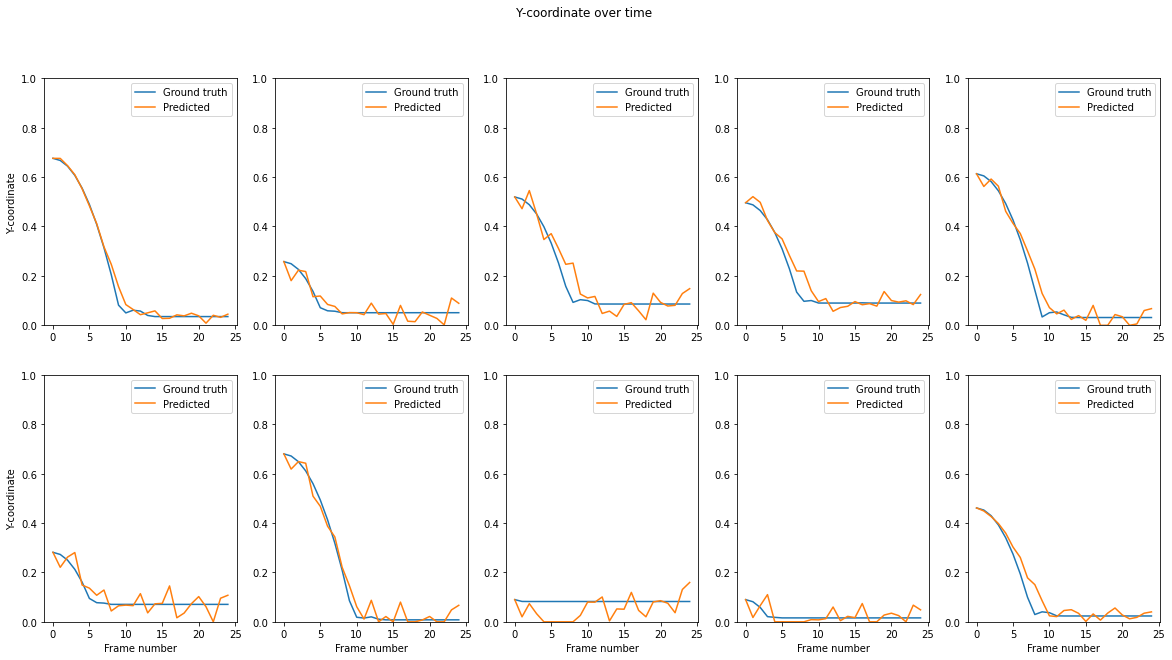

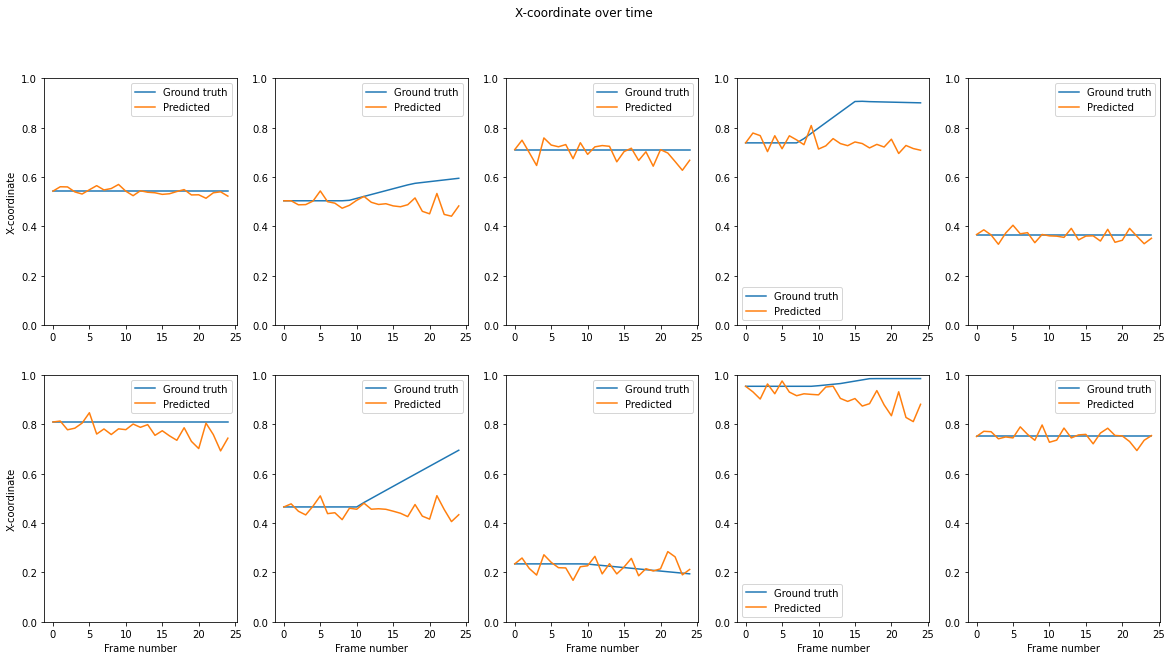

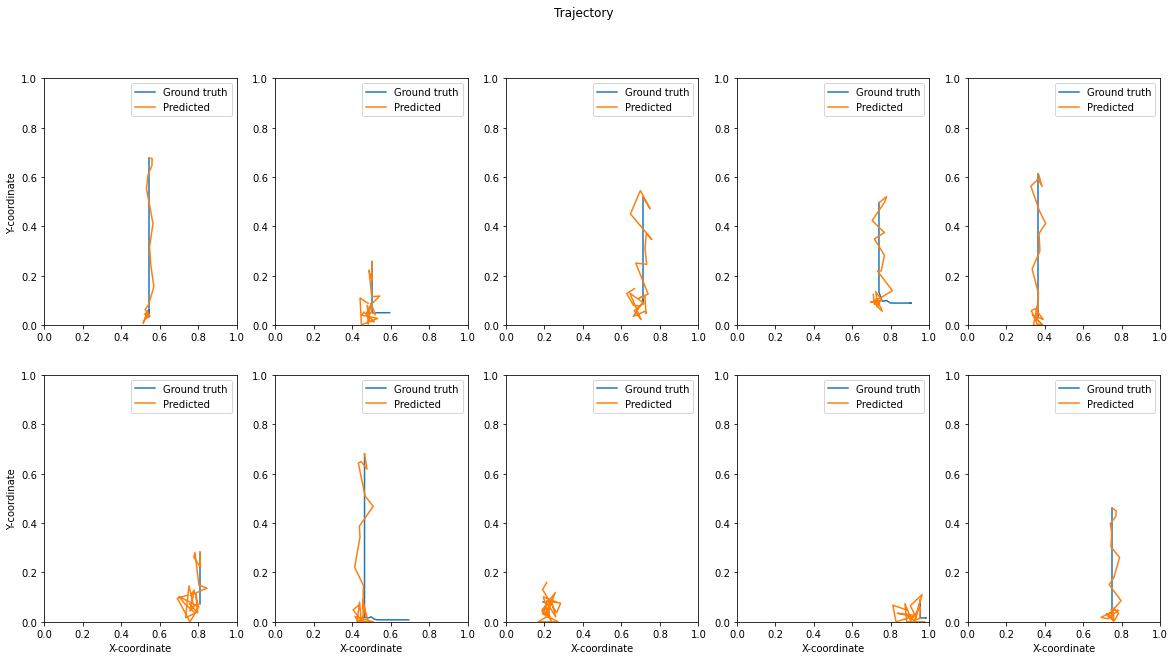

tensor(0.0532, grad_fn=<PowBackward0>)

In [4]:
gru = GRU.train_model(train_dataloader=train_dataloader, error_threshold=1000, input_dim=9, hidden_dim=64, num_rnns=1, output_dim=48, dropout_prob=0)
GRU.calculate_loss(vanila_rnn, mse_pytorch, test_dataloader, test_data, visualize_first_10_trajectories=True)

## LSTM

LSTM(
  (lstm): LSTM(9, 64, batch_first=True)
  (out): Linear(in_features=64, out_features=48, bias=True)
)
Epoch 0 complete. Training loss: 41.20650488510728
Epoch 1 complete. Training loss: 10.778571932809427
Epoch 2 complete. Training loss: 6.9750876754987985
Epoch 3 complete. Training loss: 5.914138391672168
Epoch 4 complete. Training loss: 5.531480197911151
Epoch 5 complete. Training loss: 5.354118845862104
Epoch 6 complete. Training loss: 5.252626512985444
Epoch 7 complete. Training loss: 5.184887441282626
Epoch 8 complete. Training loss: 5.1346482100198045
Epoch 9 complete. Training loss: 5.094685066258535
Epoch 10 complete. Training loss: 5.061395573429763
Epoch 11 complete. Training loss: 5.032796562038129
Epoch 12 complete. Training loss: 5.007698198052822
Epoch 13 complete. Training loss: 4.985331799311098
Epoch 14 complete. Training loss: 4.965169448958477
Epoch 15 complete. Training loss: 4.946828666783404
Epoch 16 complete. Training loss: 4.930021471809596
Epoch 17 comple

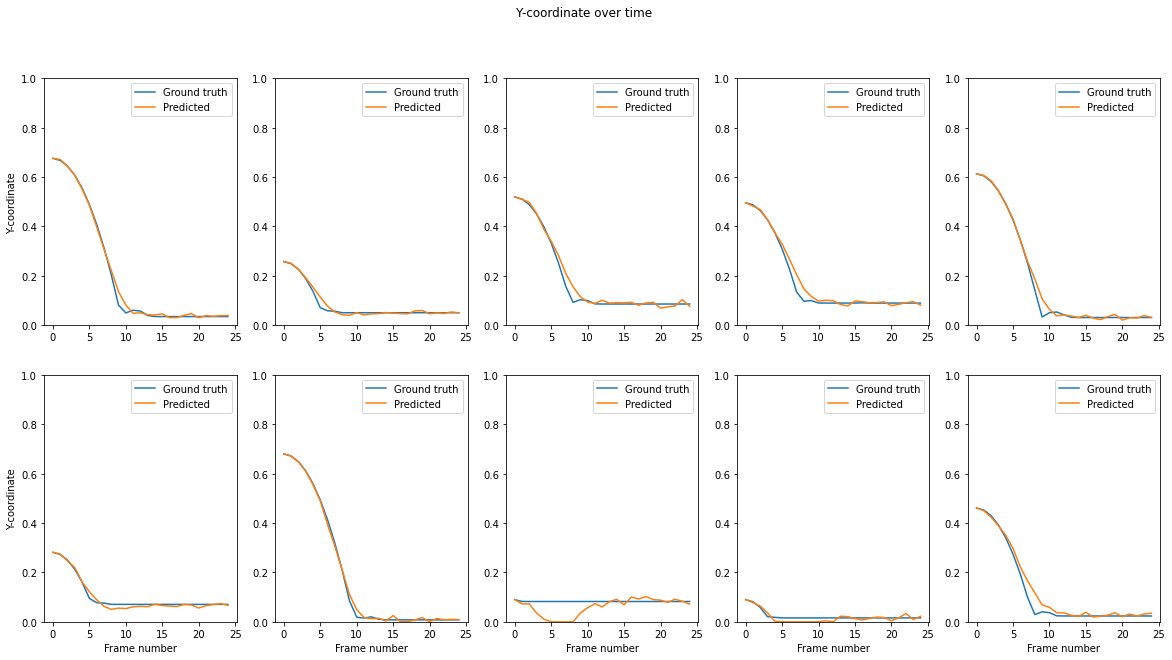

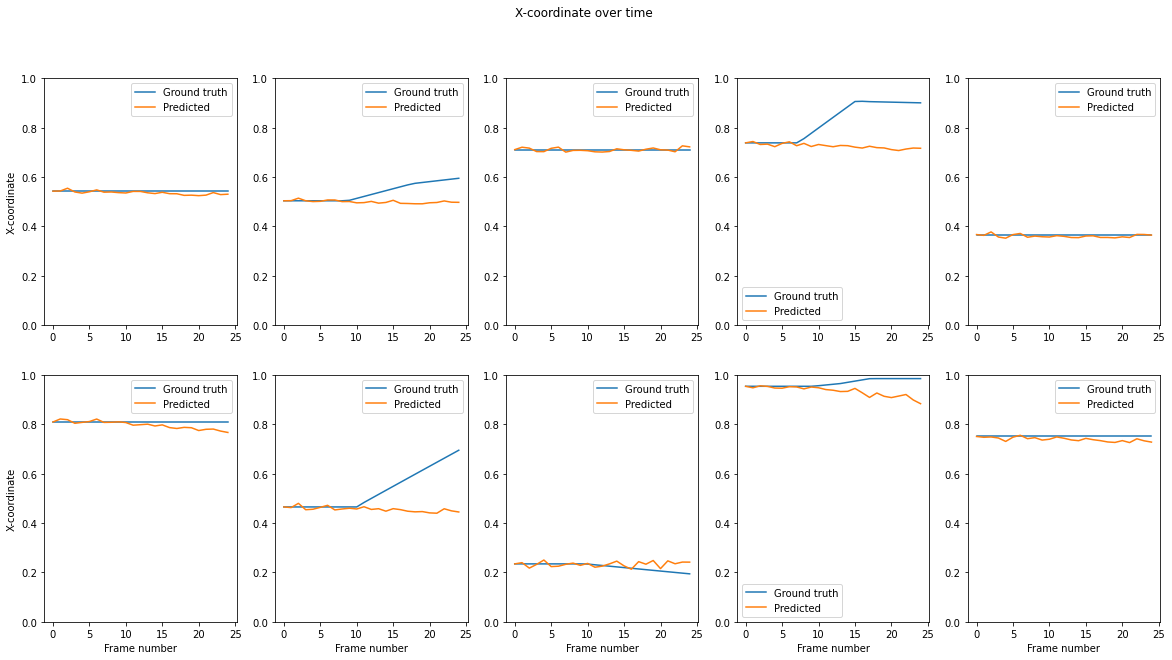

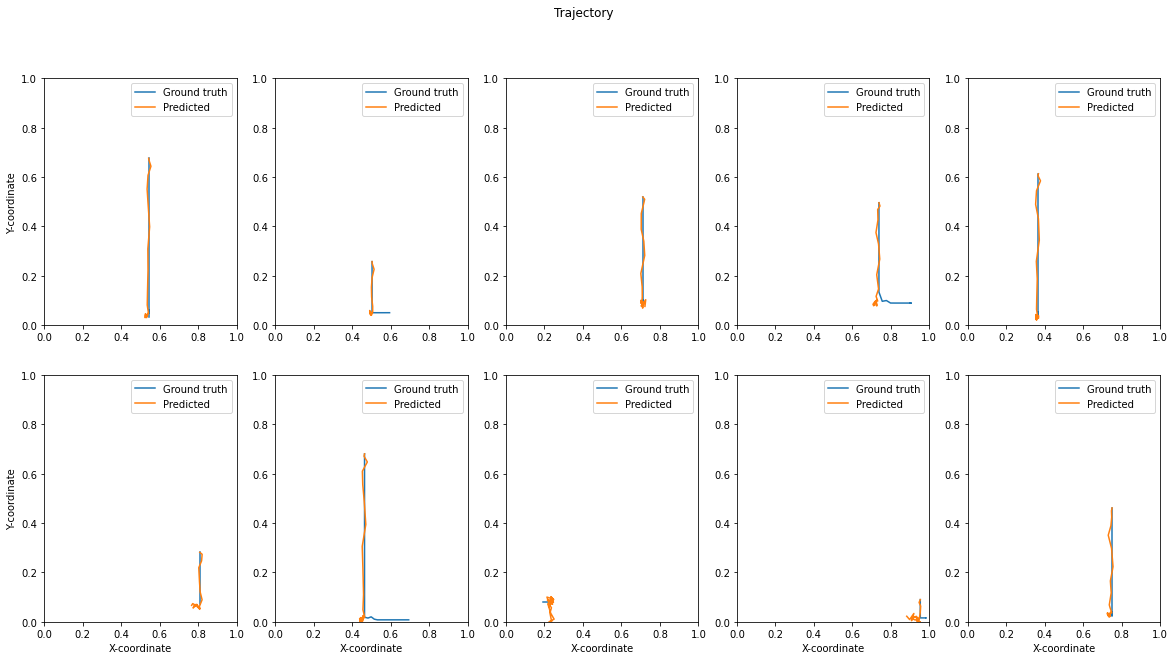

tensor(0.0450, grad_fn=<PowBackward0>)

In [11]:
lstm = LSTM.train_model(train_dataloader=train_dataloader, error_threshold=1000, num_epochs=50, input_dim=9, hidden_dim=64, num_rnns=1, output_dim=48, dropout_prob=0)
LSTM.calculate_loss(lstm, mse_pytorch, test_dataloader, test_data, visualize_first_10_trajectories=True)

## ESN

'Model-0': Model('Reservoir-0', 'Ridge-0')
Test loss:  0.11145344732748869


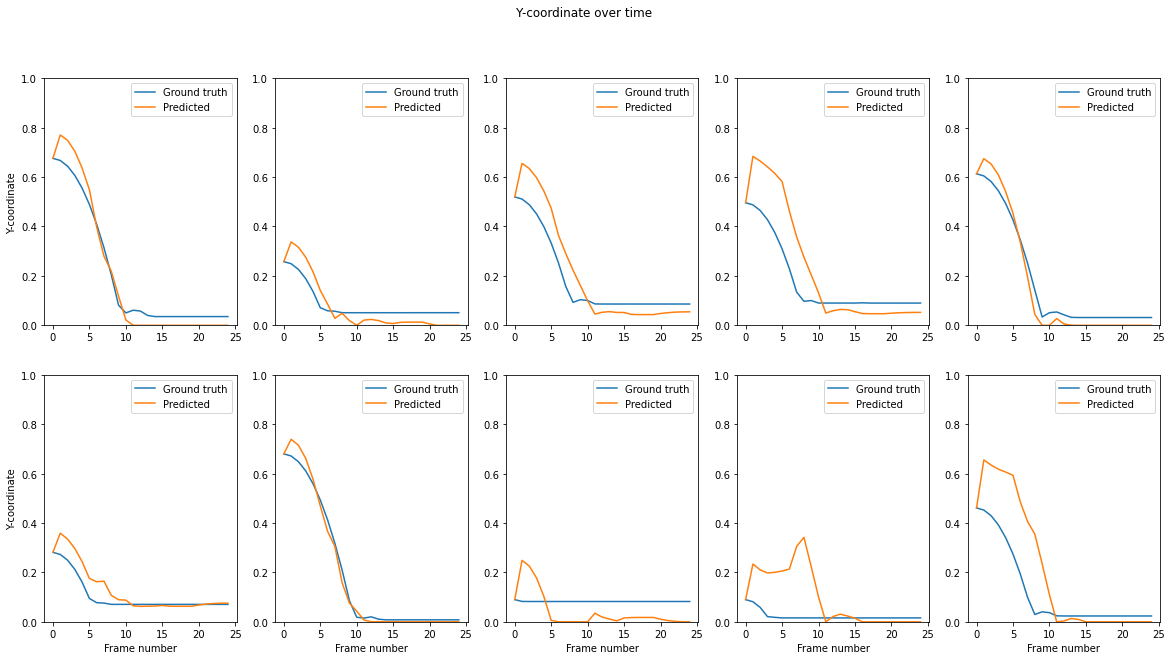

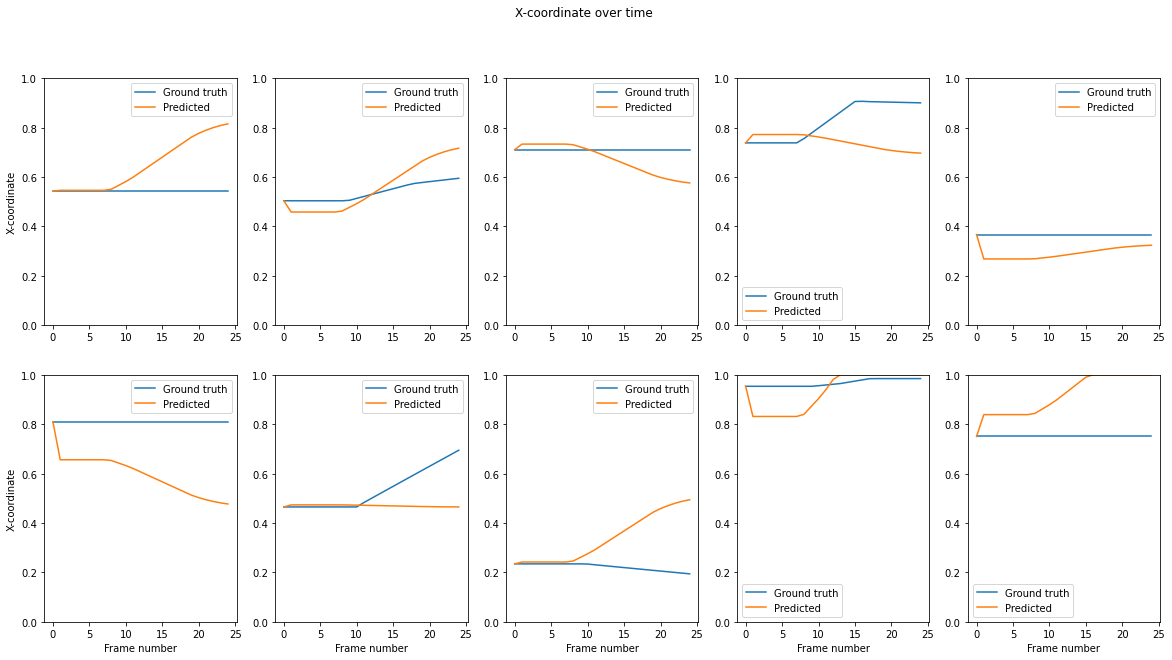

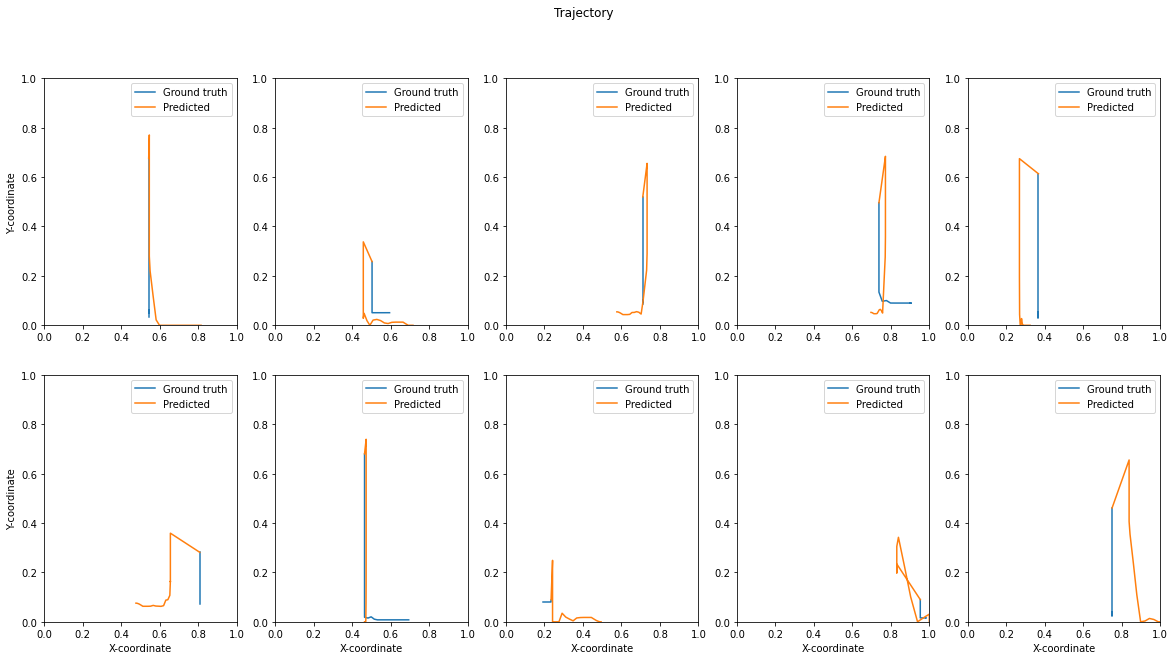

0.11145344732748869

In [12]:
rpy.set_seed(42)

esn = ESN.train_model(train_dataloader=train_dataloader, input_dim=9, reservoir_size=200, output_dim=48, leaking_rate=0.7, spectral_radius=0.95, ridge_param=0.01)
ESN.calculate_loss(esn, mse_esn, test_dataloader, test_data, visualize_first_10_trajectories=True)

## SeqESN

'Model-4': Model('Input-0', 'Reservoir-1', 'Ridge-1', 'Reservoir-2', 'Ridge-2')
Test loss:  0.1520461784537429


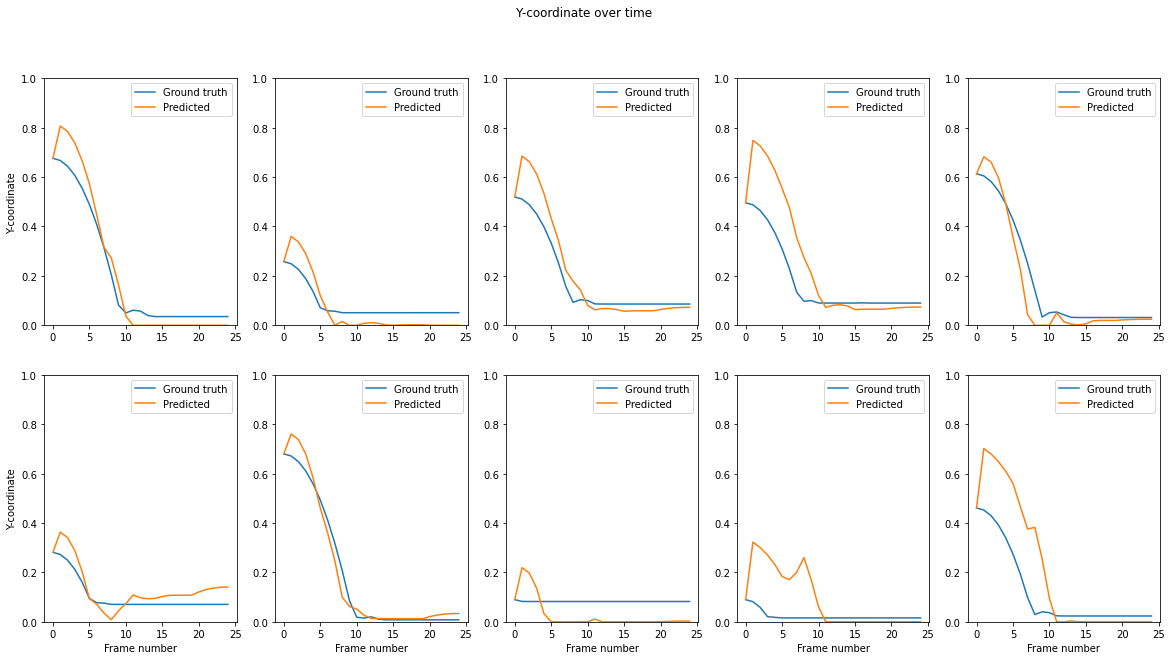

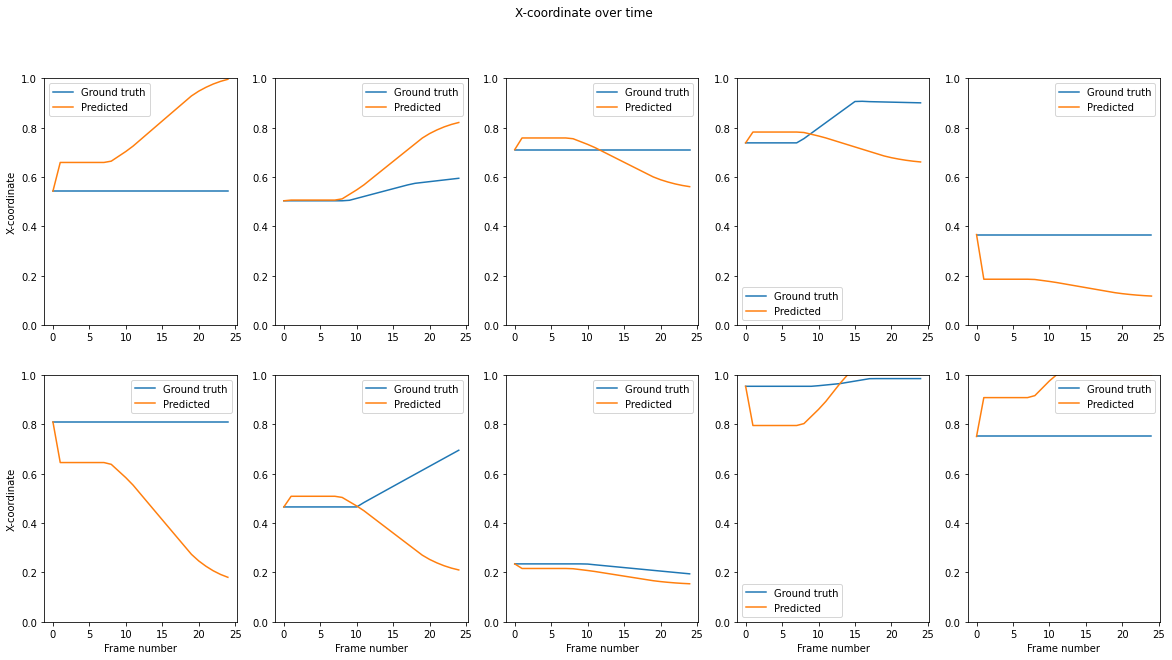

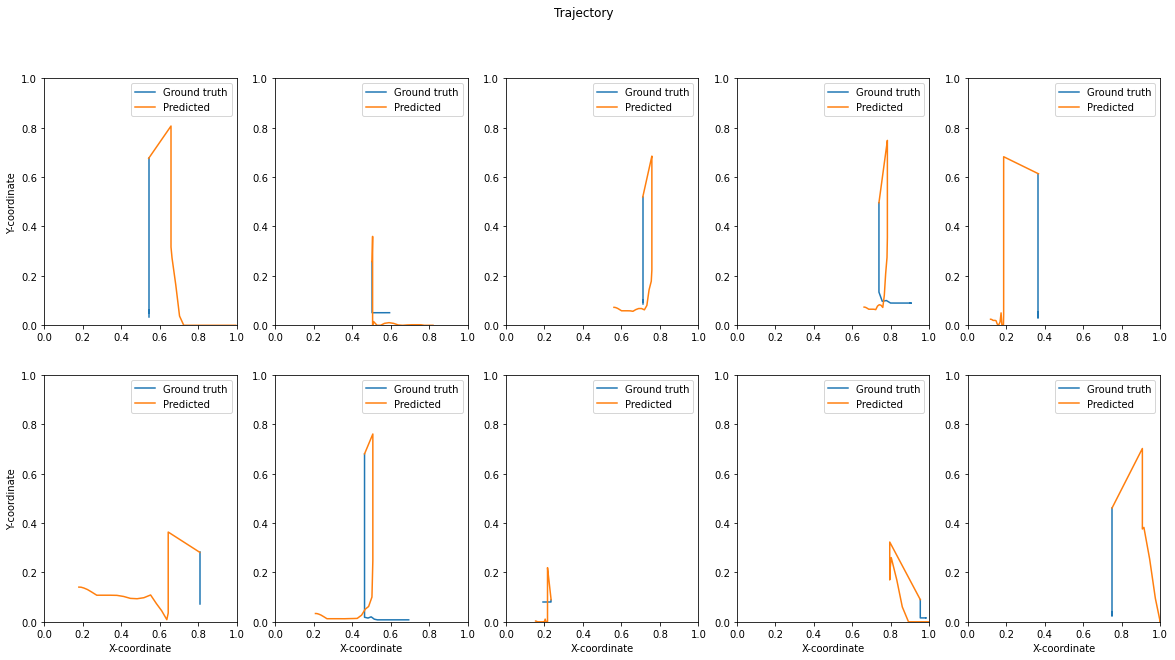

0.1520461784537429

In [13]:
rpy.set_seed(42)

seq_esn = SeqESN.train_model(train_dataloader=train_dataloader, input_dim=3, reservoir_size=200, output_dim=48, leaking_rate=0.7, spectral_radius=0.95, ridge_param=0.01, number_of_reservoirs=2)
SeqESN.calculate_loss(seq_esn, mse_esn, test_dataloader, test_data, visualize_first_10_trajectories=True)

## Parallel ESN

'Model-6': Model('Reservoir-4', 'Reservoir-3', 'Concat-0', 'Ridge-3')
Test loss:  0.11200211903731867


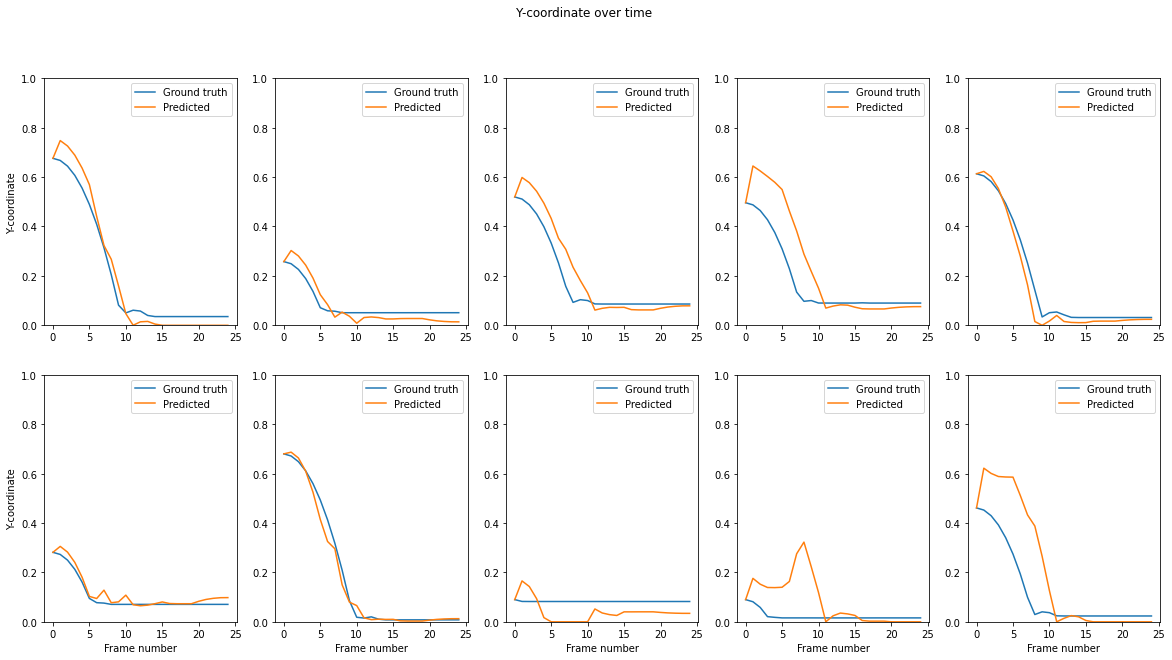

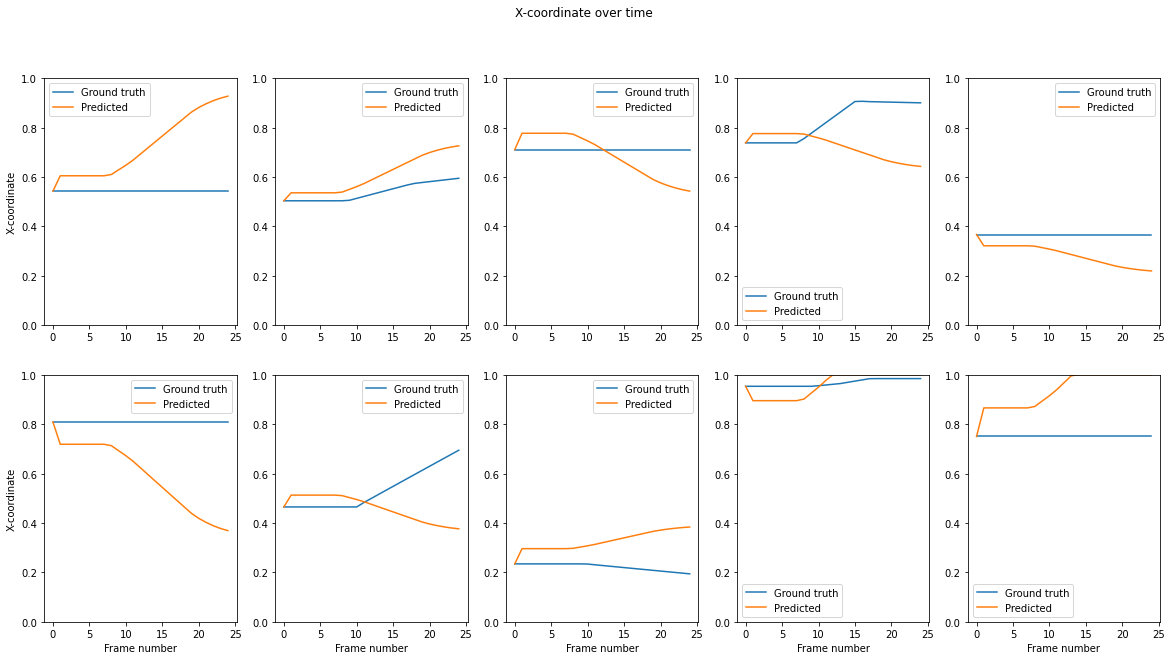

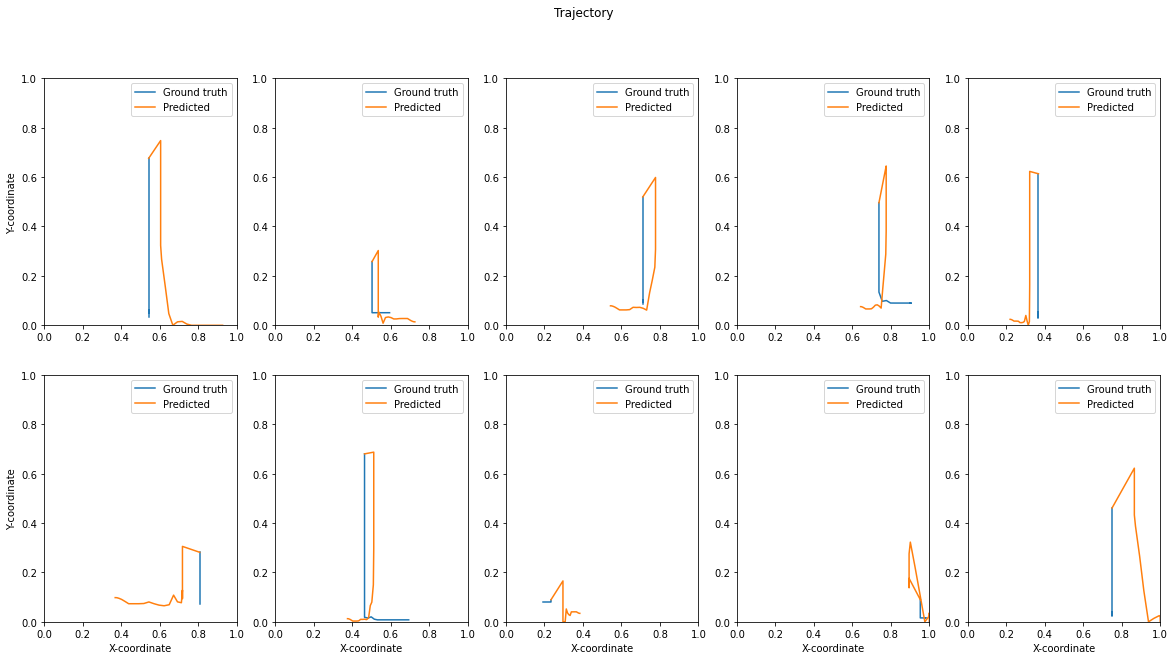

0.11200211903731867

In [14]:
rpy.set_seed(42)

parallel_esn = ParallelESN.train_model(train_dataloader=train_dataloader, input_dim=3, reservoir_size=200, output_dim=48, leaking_rate=0.7, spectral_radius=0.95, ridge_param=0.01, number_of_reservoirs=2)
ParallelESN.calculate_loss(parallel_esn, mse_esn, test_dataloader, test_data, visualize_first_10_trajectories=True)

## Grouped ESN

'Model-7': Model('Reservoir-5', 'Reservoir-6', 'Concat-1', 'Ridge-4')
Test loss:  0.1315517210888826


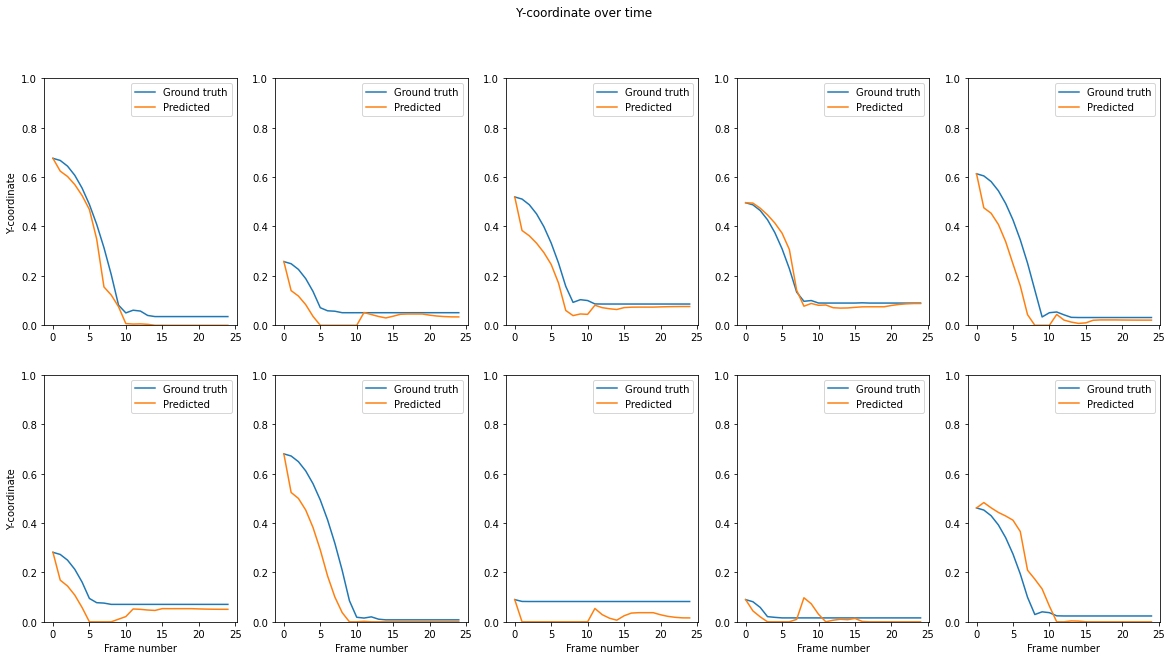

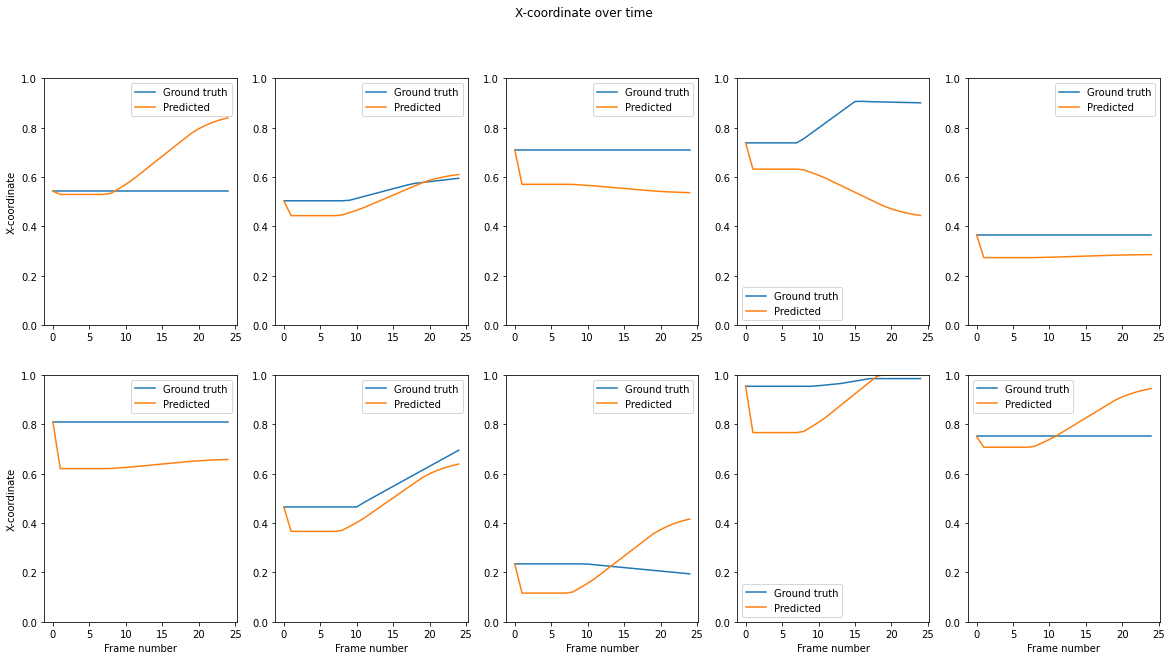

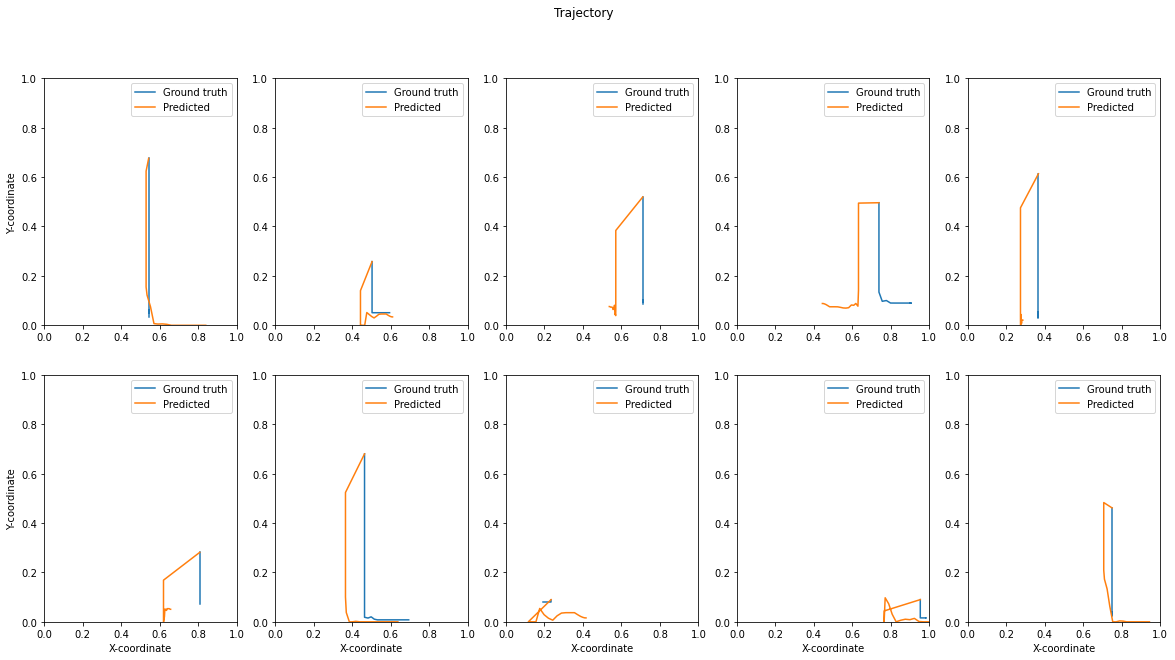

0.1315517210888826

In [15]:
grouped_esn = GroupedESN.train_model(train_dataloader=train_dataloader, input_dim=3, reservoir_size=200, output_dim=48, leaking_rate=0.7, spectral_radius=0.95, ridge_param=0.01, number_of_reservoirs=2)
GroupedESN.calculate_loss(grouped_esn, mse_esn, test_dataloader, test_data, visualize_first_10_trajectories=True)